In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.sparse as sparse
import warnings
import matplotlib.pyplot as plt
from langdetect import detect
from googletrans import Translator
import re
import string
from sentence_transformers import SentenceTransformer

warnings.filterwarnings('ignore')

# Training data

In [6]:
train_data = pd.read_csv(r'E:/SkyBug Technology Internship/Skybug-Movie-Genre-Classification/data/train_data.txt', sep=":::", names=["Title","Genre","Summary"])
train_data.head()

,Title,Genre,Summary
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


## Exploratory Analysis

### Unique genres

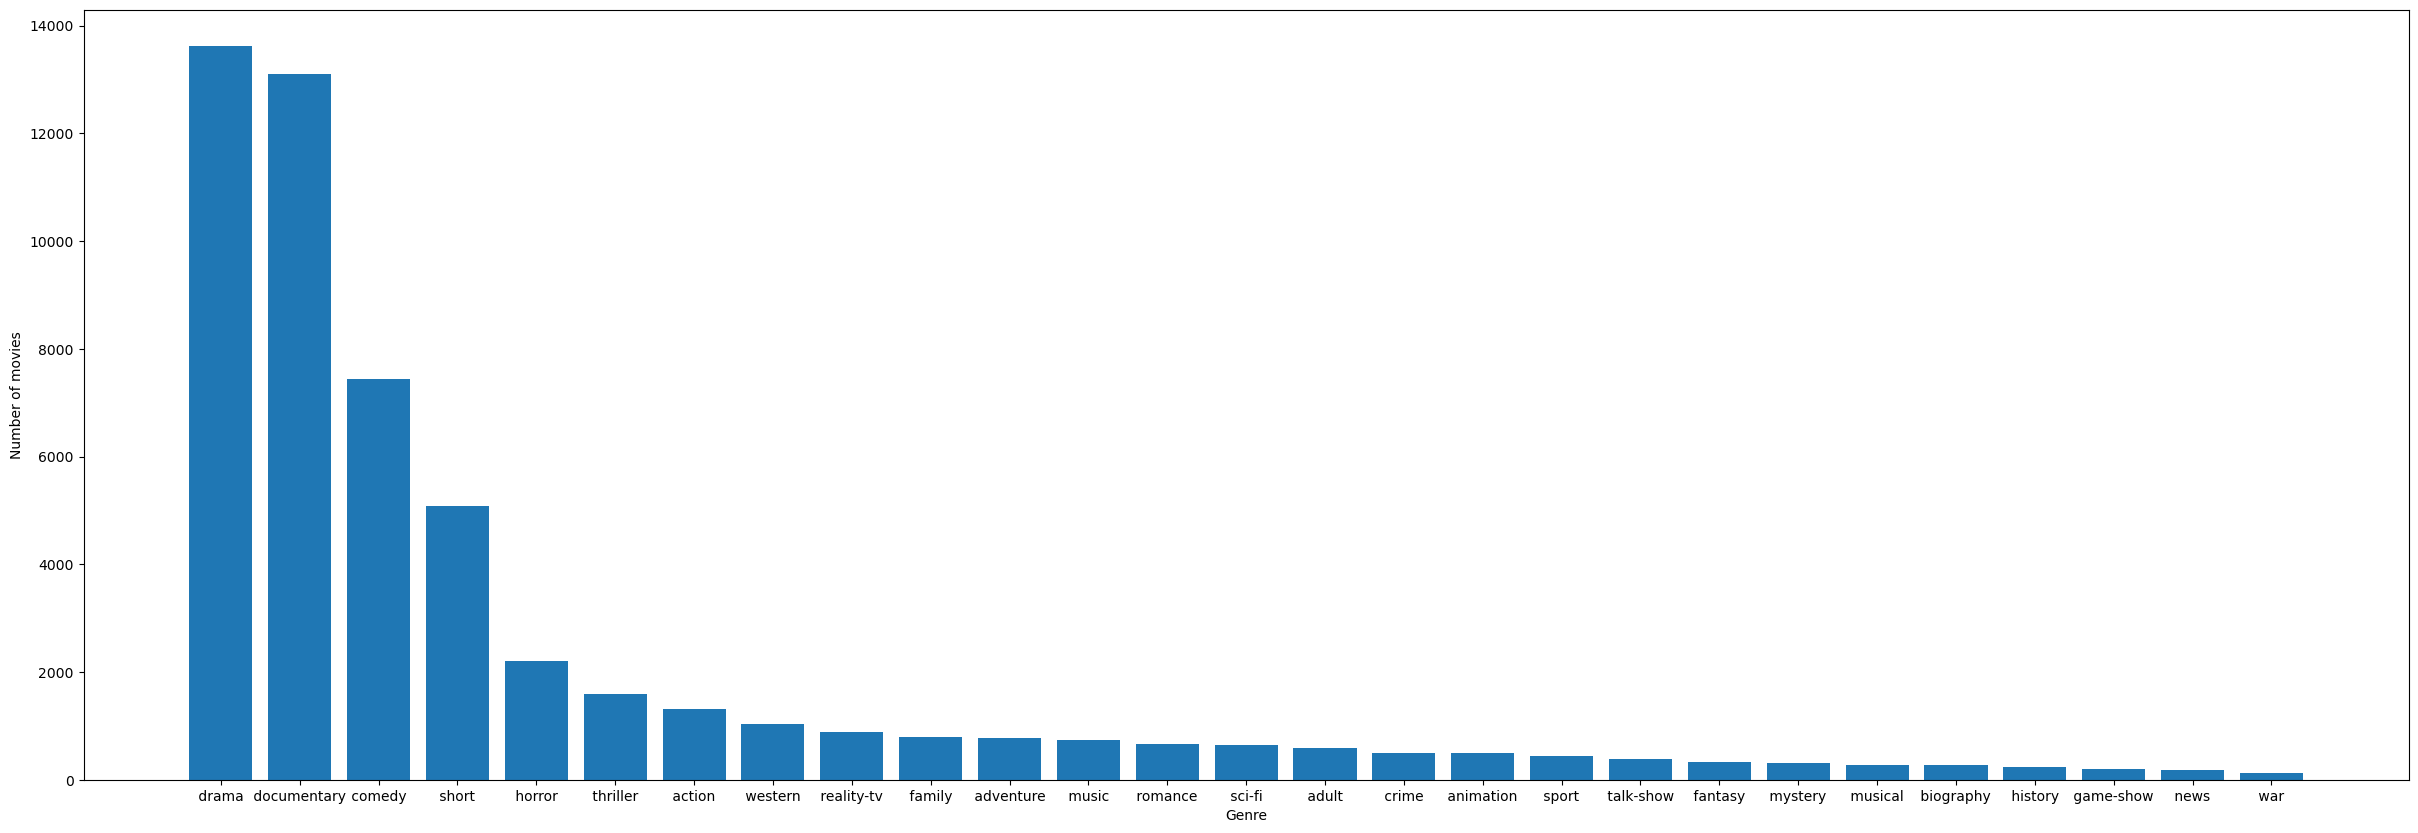

In [9]:
counts = train_data['Genre'].value_counts()

fig,axis = plt.subplots(figsize=(30,10))
plt.bar(counts.index, counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.show()

### Unique languages

In [10]:
uniq_langs = set()
langs = []
for i in list(train_data["Summary"]):
    lang = detect(i)
    langs.append(lang)
    uniq_langs.add(lang)

train_data["Language"] = langs
print(uniq_langs)

{'sq', 'en', 'es', 'de', 'nl', 'it', 'ca', 'pt', 'hu', 'no', 'sl', 'fr'}


## Data Preprocessing

In [7]:
# train_data.to_csv('data/train_data_with_languages.csv')
train_data = pd.read_csv('../data/train_data_with_languages.csv', index_col=0)
train_data.head()

,Title,Genre,Summary,Language
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,en
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,en
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,en
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,en
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,en


In [15]:
# Movies whose descriptions are not in english 
len(train_data[~train_data.Language.isin(['en'])])

373

In [ ]:
# So we have multiple genres of movies - drama, documentary, etc. 
# But out of those, the number of entries of a few genres is very high, which might be a cause of bias.

# We also have multiple languages in the description. 
# But the number is very small compared to English. Hence, for simplicity, we shall only consider those in English for now.

In [4]:
train_data = pd.read_csv('../data/train_data_with_languages.csv', index_col=0)
train_data = train_data[train_data['Language']=='en']
train_data.head()

,Title,Genre,Summary,Language
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,en
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,en
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,en
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,en
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,en


In [8]:
def clean_text(text):
    text = re.sub('Mail <svaradi@sprynet.com> for translation. ','',text)
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(f'[{string.punctuation}]','',text)
    text = re.sub(f'[{string.digits}]','',text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    return text

train_data['Summary'] = train_data['Summary'].apply(clean_text)
train_data.head()

,Title,Genre,Summary,Language
1,Oscar et la dame rose (2009),drama,Listening in to conversation between his doct...,en
2,Cupid (1997),thriller,brother and sister with past incestuous relat...,en
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,en
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,en
5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,en


The number of datapoints in "drama", "documentary","comedy", "short" is way larger and skewed compared to other classes. Hence we shall simply clump all the other classes together.

In [9]:
l = [' thriller ',' adult ',' crime ',' reality-tv ',' horror ',' sport ',' animation ',' action ',' fantasy ',' sci-fi ',' music ',' adventure ',' talk-show ',' western ',' family ',' mystery ',' history ',' news ',' biography ',' romance ',' game-show ',' musical ',' war ']
train_data["Genre"] = train_data["Genre"].replace(to_replace=l,value='other')
train_data["Genre"] = train_data["Genre"].replace(to_replace=[' drama '],value='drama')
train_data["Genre"] = train_data["Genre"].replace(to_replace=[' documentary '],value='documentary')
train_data["Genre"] = train_data["Genre"].replace(to_replace=[' comedy '],value='comedy')
train_data["Genre"] = train_data["Genre"].replace(to_replace=[' short '],value='short')

train_data.head()

,Title,Genre,Summary,Language
1,Oscar et la dame rose (2009),drama,Listening in to conversation between his doct...,en
2,Cupid (1997),other,brother and sister with past incestuous relat...,en
3,"Young, Wild and Wonderful (1980)",other,As the bus empties the students for their fie...,en
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,en
5,The Unrecovered (2007),drama,The films title refers not only to the unreco...,en


In [20]:
X_train = train_data["Summary"]
Y_train = train_data["Genre"]
print("Before vectorisation: ",X_train.shape)

# model = SentenceTransformer('all-MiniLM-L6-v2')
# sentence_embeddings = model.encode(list(X_train))

print("After vectorisation:",sentence_embeddings.shape)

Before vectorisation:  (54214,)
After vectorisation: (54214, 384)


In [22]:
x_train = pd.DataFrame(sentence_embeddings)
x_train.head()

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.100113,0.047543,-0.017568,0.022169,-0.008113,0.066285,0.044294,-0.001988,0.023515,-0.096185,...,0.017540,-0.043811,-0.008418,0.009575,0.004424,0.008141,0.030389,0.016892,0.053477,0.006697
1,-0.030218,0.053955,-0.115293,-0.023189,-0.023016,-0.004647,0.005791,-0.061413,0.050253,-0.013987,...,0.017131,-0.097131,0.016678,0.090240,-0.049587,0.036313,0.082832,-0.045983,0.112446,-0.038247
2,0.055413,0.067351,0.057936,0.040602,0.043434,-0.006236,0.001159,-0.051813,0.067461,-0.027024,...,0.019969,-0.039349,0.003698,0.012504,-0.134172,0.041827,-0.004911,0.070233,-0.081329,-0.061537
3,-0.051497,-0.011621,0.006114,-0.038689,-0.042185,0.065028,0.019505,0.038383,0.037409,-0.109517,...,0.027292,-0.039455,-0.035343,0.039774,-0.003396,0.129379,-0.002248,0.027673,0.096751,-0.032260
4,-0.044385,-0.024631,-0.002330,0.082546,0.054457,-0.025413,0.047433,-0.054462,-0.003557,-0.085276,...,0.063805,0.055537,-0.010916,0.055499,-0.081727,0.052276,0.066995,-0.018595,-0.091746,-0.009528


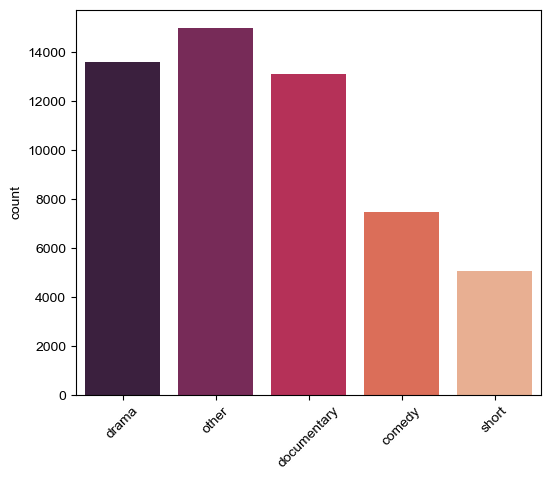

In [23]:
plt.figure(figsize=(6,5))
sns.countplot(data=Y_train,x=Y_train.values,palette='rocket')
sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation=45)
plt.show()

In [39]:
x_train.to_csv('E:/SkyBug Technology Internship/Skybug-Movie-Genre-Classification/data/x_train.csv', index=False)
Y_train.to_csv('E:/SkyBug Technology Internship/Skybug-Movie-Genre-Classification/data/y_train.csv', index=False) 

# Testing data

In [30]:
test_data = pd.read_csv(r'E:/Skybug Technology Internship/Skybug-Movie-Genre-Classification/data/test_data_solution.txt', sep=":::", names=["Id","Title","Genre","Summary"])
X_test = test_data["Summary"]
Y_test = test_data["Genre"]

## Exploratory analysis

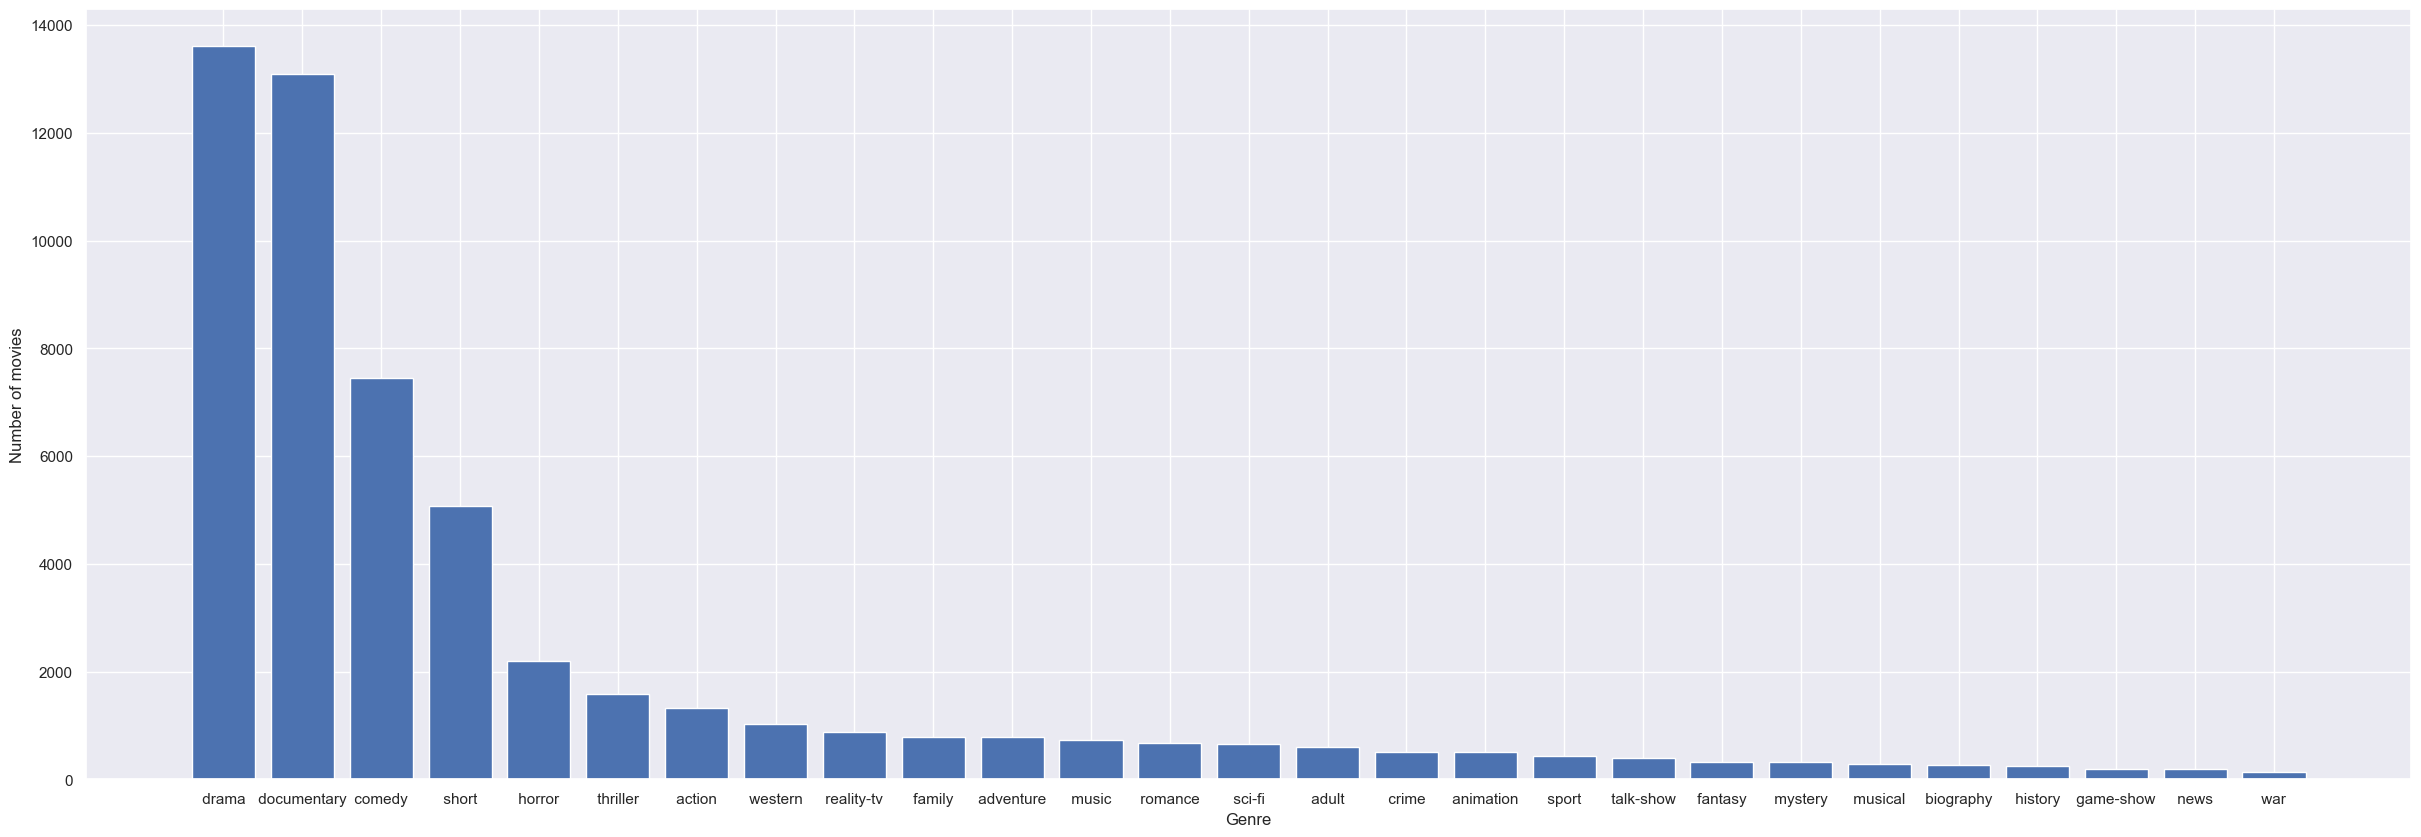

In [31]:
counts = Y_test.value_counts()

fig,axis = plt.subplots(figsize=(30,10))
plt.bar(counts.index, counts.values)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
plt.show()

In [32]:
X_test = X_test.apply(clean_text)
X_test.head()

0     LR Brane loves his life  his car his apartmen...
1     Spain March  Quico is very naughty child of t...
2     One year in the life of Albin and his family ...
3     His father has died he hasnt spoken with his ...
4     Before he was known internationally as martia...
Name: Summary, dtype: object

## Data Preprocessing

In [33]:
l = [' thriller ',' adult ',' crime ',' reality-tv ',' horror ',' sport ',' animation ',' action ',' fantasy ',' sci-fi ',' music ',' adventure ',' talk-show ',' western ',' family ',' mystery ',' history ',' news ',' biography ',' romance ',' game-show ',' musical ',' war ']
Y_test = Y_test.replace(to_replace=l,value='other')
Y_test = Y_test.replace(to_replace=[' drama '],value='drama')
Y_test = Y_test.replace(to_replace=[' documentary '],value='documentary')
Y_test = Y_test.replace(to_replace=[' comedy '],value='comedy')
Y_test = Y_test.replace(to_replace=[' short '],value='short')

Y_test.head()

0          other
1         comedy
2    documentary
3          drama
4          drama
Name: Genre, dtype: object

In [34]:
print("Before vectorisation: ",X_test.shape)

model = SentenceTransformer('all-MiniLM-L6-v2')
sentence_embeddings = model.encode(list(X_test))

print("After vectorisation:",sentence_embeddings.shape)

Before vectorisation:  (54200,)
After vectorisation: (54200, 384)


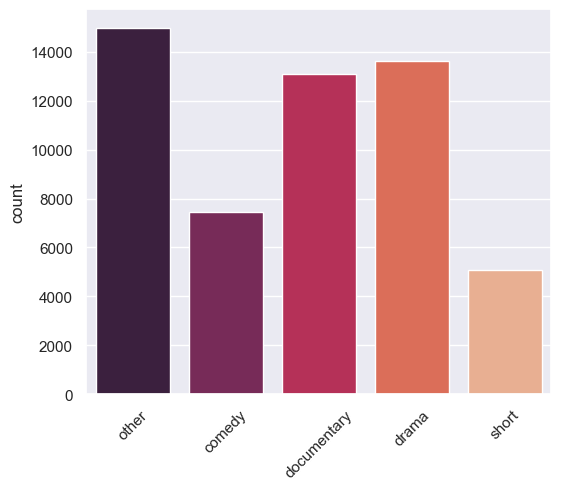

In [35]:
plt.figure(figsize=(6,5))
sns.countplot(data=Y_test,x=Y_test.values,palette='rocket')
sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation=45)
plt.show()

In [37]:
X_test = pd.DataFrame(sentence_embeddings)
X_test.to_csv('E:/SkyBug Technology Internship/Skybug-Movie-Genre-Classification/data/x_test.csv', index=False)

Y_test.to_csv('E:/SkyBug Technology Internship/Skybug-Movie-Genre-Classification/data/y_test.csv', index=False) 